In [418]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import pywt
import matplotlib.pyplot as plt

from sklearn.utils import shuffle as shuffle_sklearn
from tensorboard.plugins.hparams import api as hp
from tqdm import tqdm
from scipy import signal

from scipy.signal import butter, sosfiltfilt, hilbert

# Loading Data
----
We start by loading the data of a specific subject. Since the headset is using 256 Hz and have used 8 seconds in the training process, we get samples of 2048 length. The shape of the data will be: **Number of trials x Number of channels x Samples**


In [523]:
from os import truncate
import numpy as np
import mne 
import pandas as pd

from enum import IntEnum

def gdfData(user):
    cue_offset = 1000           # ms
    activity_duration = 3000    # ms

    class Label(IntEnum):
        CLASS1 = 0x301
        CLASS2 = 0x302
        CLASS3 = 0x303
        CLASS4 = 0x304

    electrode_names = [ 'Fz', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 
                        'C4', 'C6', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POZ']


    raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])

    data_frame = raw.to_data_frame()
    annotations = raw.annotations.to_data_frame()


    # rename electrodes according to 10-20 system
    keys = data_frame.keys()
    for i in range(len(keys)):
        if keys[i] == 'time':
            continue
        data_frame.rename(columns = {keys[i]:electrode_names[i-1]}, inplace = truncate)


    trials_of_class_1 = list()
    trials_of_class_2 = list()
    trials_of_class_3 = list()
    trials_of_class_4 = list()

    #create relative time consistent between data and annotations
    base_time = annotations['onset'][0].timestamp()*10**3 # in ms


    #mask data with relevant EEG information (motor imagery)

    for i in range(len(annotations.index)):
        cur_ann = int(annotations['description'][i])
        start = annotations['onset'][i].timestamp()*10**3 - base_time + cue_offset # in ms
        end = start + activity_duration
        mask = (data_frame['time']>start) & (data_frame['time']<=end)
        trial = data_frame.loc[mask]
        trial = trial.drop(['time'],axis=1)
        trial = trial.to_numpy()
            
        if  cur_ann == Label.CLASS1:
            trials_of_class_1.append(trial)

        elif cur_ann == Label.CLASS2:
            trials_of_class_2.append(trial)

        elif cur_ann == Label.CLASS3:
            trials_of_class_3.append(trial)

        elif cur_ann == Label.CLASS4:
            trials_of_class_4.append(trial)

    #remove trials with length other than 750 samples
    filtered_trials_of_class_1 = list()
    for i in range(len(trials_of_class_1)):
        if (len(trials_of_class_1[i])==750):
            filtered_trials_of_class_1.append(trials_of_class_1[i])

    filtered_trials_of_class_2 = list()
    for i in range(len(trials_of_class_2)):
        if (len(trials_of_class_2[i])==750):
            filtered_trials_of_class_2.append(trials_of_class_2[i])

    filtered_trials_of_class_3 = list()
    for i in range(len(trials_of_class_3)):
        if (len(trials_of_class_3[i])==750):
            filtered_trials_of_class_3.append(trials_of_class_3[i])

    filtered_trials_of_class_4 = list()
    for i in range(len(trials_of_class_4)):
        if (len(trials_of_class_4[i])==750):
            filtered_trials_of_class_4.append(trials_of_class_4[i])


    all_trials = filtered_trials_of_class_1+filtered_trials_of_class_2+filtered_trials_of_class_3+filtered_trials_of_class_4
    #print(len(all_trials))

    all_trials = np.stack(all_trials)
    all_trials = all_trials.transpose(0, 2, 1)

    #print(all_trials.shape) #shape currently is 288 x 22 x 750

    #forgot Alex' name for it, corresponding to all_trials array
    magic_vectors =     len(filtered_trials_of_class_1)*[[0,0,0,1]] \
                    +   len(filtered_trials_of_class_2)*[[0,0,1,0]] \
                    +   len(filtered_trials_of_class_1)*[[0,1,0,0]] \
                    +   len(filtered_trials_of_class_1)*[[1,0,0,0]]
    
    return all_trials, magic_vectors


titles = [f'A0{i}T' for i in range(1, 10)]
print(titles)
data, one_hot = [], []
for elem in titles:
    trial, ohot = gdfData(elem)
    data.append(trial)
    one_hot.append(np.array(ohot))

['A01T', 'A02T', 'A03T', 'A04T', 'A05T', 'A06T', 'A07T', 'A08T', 'A09T']
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A02T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A03T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A04T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A05T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A06T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A07T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A08T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)
Extracting EDF parameters from /Users/alexander/Documents/Uni/Master/SST Project/Code/Data/EEG_2a/A09T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/alexander/Documents/Uni/Master/SST Project/Code/projectvenv/lib/python3.8/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/var/folders/_c/td041vkd25qf7j967n0yrgk40000gn/T/ipykernel_59832/652654843.py:22: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(f'Data/EEG_2a/{user}.gdf', exclude = ['EOG-left', 'EOG-central', 'EOG-right'])


288
(288, 22, 750)


In [524]:
RAW_EEG = np.vstack(data)
ONE_HOT = np.vstack(one_hot)

In [541]:
def read_single_data(eeg_path, marker_path):
    keys = ['Timestamp', 'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', "EEG.P7", "EEG.O1",
              "EEG.O2", "EEG.P8", "EEG.T8", "EEG.FC6", "EEG.F4", "EEG.F8", "EEG.AF4"]
    
    eeg_data = pd.read_csv(eeg_path, skiprows=[0]).loc[:, keys]
    eeg_marker = pd.read_csv(marker_path)
    num_markers = len(eeg_marker)
    num_ts = len(eeg_data)
    num_channels = 14
    num_samples = 2048

    # We start with zero-filled arrays for the raw data and the one hot vector, which is needed for the training
    raw_data = np.zeros(shape=(num_markers, num_channels,  num_samples))
    one_hot_coding = np.zeros(shape=(num_markers, 4))
    # The start and end values of the marker need to be adapted since they don't match an entry
    # from the data set
    for idx in range(num_markers):
        start_marker, end_marker, _, marker_value = eeg_marker.loc[idx, :]
        start_aprox = np.around(start_marker, 1)
        end_aprox = np.around(end_marker, 1)
        timestamps_aprox = np.around(eeg_data.loc[:,'Timestamp'], 1)
        
        # We take the last entry of the rounded elements, also since we sample with 256 Hz, 
        # this follows adn entry width of 256 Hz * 8s = 2048 
        start_idx = np.where(timestamps_aprox == start_aprox)[0][-1]
        end_idx = start_idx + num_samples - 1
        
        eeg_segment = eeg_data.loc[start_idx:end_idx, keys[1:]].T
        raw_data[idx] = eeg_segment
        
        one_hot_coding[idx][marker_value] = 1
        
    return raw_data, one_hot_coding
        

def read_multiple_data(subject):
    path = f'{os.getcwd()}/Data/{subject}'
    sub_directories = os.listdir(path)
    filtered_sub_directories = [directory for directory in sub_directories if 'Session' in directory]
    paired_files = []
    for filtered_sub_directory in filtered_sub_directories:
        files = os.listdir(f'{path}/{filtered_sub_directory}')
        filtered_files = [file for file in files if ('EEG' in file) or ('MARKER' in file)]
        num_files = len(filtered_files)//2
        sub_path = f'{path}/{filtered_sub_directory}'
        paired_files += [(f'{sub_path}/EEG_{i}.csv', f'{sub_path}/MARKERS_{i}.csv') for i in range(1, num_files)]
    
    
    data_list = []
    one_hot_list = []
    
    for pair in paired_files:
        rdata, one_hot_vec = read_single_data(pair[0], pair[1])
        data_list.append(rdata)
        one_hot_list.append(one_hot_vec)
    
    eeg_stack = np.vstack(data_list)
    one_hot_stack = np.vstack(one_hot_list)
    
    return eeg_stack, one_hot_stack

RAW_EEG_DATA_L, ONE_HOT_VEC_L = read_multiple_data('Luca')
RAW_EEG_DATA_J, ONE_HOT_VEC_J = read_multiple_data('Johannes')
#RAW_EEG_DATA_R, ONE_HOT_VEC_R = read_multiple_data('Sandeep')

RAW_EEG_DATA_N, ONE_HOT_VEC_N = np.vstack([RAW_EEG_DATA_L, RAW_EEG_DATA_J]), \
                                np.vstack([ONE_HOT_VEC_L, ONE_HOT_VEC_J])
#RAW_EEG_DATA, ONE_HOT_VEC = shuffle_sklearn(RAW_EEG_DATA_N, ONE_HOT_VEC_N)


In [543]:
print(RAW_EEG.shape)
print(ONE_HOT.shape)

#RAW_EEG_DATA, ONE_HOT_VEC = shuffle_sklearn(RAW_EEG, ONE_HOT)
RAW_EEG_DATA, ONE_HOT_VEC = shuffle_sklearn(RAW_EEG_DATA_N, ONE_HOT_VEC_N)

RAW_EEG_TRAIN, ONE_HOT_VEC_TRAIN = RAW_EEG_DATA[100:], ONE_HOT_VEC[100:]
RAW_EEG_TEST, ONE_HOT_VEC_TEST = RAW_EEG_DATA[:100], ONE_HOT_VEC[:100]

print(RAW_EEG_TRAIN.shape)
print(ONE_HOT_VEC_TRAIN.shape)
print(RAW_EEG_TEST.shape)
print(ONE_HOT_VEC_TEST.shape)

(2592, 22, 750)
(2592, 4)
(440, 14, 2048)
(440, 4)
(100, 14, 2048)
(100, 4)


# Preprocessing
----
The first preprocessing step is the normalisation. The scheme for this is the follwing. Let us consider $\mathbf{X}_{\mathrm{EEG}}=[\mathbf{x}^{(1)},\ldots, \mathbf{x}^{(N)}]\in \mathbb{R}^{k \times N}$, where $k$ are the amount of channels and $N$ the observations. Then we take a vector $\mathbf{x}_{k}=[\mathrm{x}^{(1)}_{k},\ldots, \mathrm{x}^{(N)}_{k}]$, calculate its mean $\mu_{k}$, standard deviation $\sigma_{k}$ and normalise it as $\mathbf{\bar{x}}_{k}=[\frac{\mathrm{x}^{(1)}_{k}-\mu_{k}}{\sigma_{k}},\ldots, \frac{\mathrm{x}^{(N)}_{k}-\mu_{k}}{\sigma_{k}}]$. Repeating this for each channel, we get $\mathbf{\bar{X}}_{\mathrm{EEG}}$.

In [545]:
def preprocessing(raw_data):
    num_labels = raw_data.shape[0]
    num_channels = raw_data.shape[1]
    observations = raw_data.shape[2]
    
    preprocessed_data = np.zeros(shape=(num_labels, num_channels, observations))
    
    for label_idx in range(num_labels):
        for channel_idx in range(num_channels):
            mean = np.mean(raw_data[label_idx][channel_idx])
            standard_deviation = np.std(raw_data[label_idx][channel_idx])
            preprocessed_data[label_idx][channel_idx] = np.array([(i-mean)/standard_deviation for i in raw_data[label_idx][channel_idx]])
    
    return preprocessed_data

EEG_TRAIN = preprocessing(RAW_EEG_TRAIN)
EEG_TEST = preprocessing(RAW_EEG_TEST)

# Feature Extraction
## One Dimension-Aggregate Approximation (1d-AX)
----
1d-AX  can calculated by taking $\mathrm{\bar{x}}_{k}=[\mathrm{\bar{x}}^{(1)}_{k},\ldots, \mathrm{\bar{x}}^{(N)}_{k}]$ for each channel, and divide it into $m$ segements $\mathbf{y}_{k}^{(i)}$ of equal length $q=\frac{N}{m}$. Afterwards, we take a sampled version of $\mathbf{y}_{k}^{(i)}$ and apply linear regression to it.

In [546]:
def segment_data(data, win_length):
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    num_samples = data.shape[2]
    num_segments = num_samples//win_length
    
    sliced_eeg_data = np.zeros(shape=(num_trials, num_channels, num_segments,  win_length))
    
    for trial_idx in range(num_trials):
        for channel_idx in range(num_channels):
            for segment_idx in range(num_segments):
                lower_limit = segment_idx*win_length
                upper_limit = (segment_idx+1)*win_length 
                sliced_eeg_data[trial_idx][channel_idx][segment_idx] = data[trial_idx][channel_idx][lower_limit:upper_limit]
    return sliced_eeg_data

def linear_regression(segm_data):
    num_trials = segm_data.shape[0]
    num_channels = segm_data.shape[1]
    num_segments = segm_data.shape[2]
    num_samples = segm_data.shape[3]
    
    K = np.zeros(shape=(num_trials, num_channels, num_segments))
    A = np.zeros(shape=(num_trials, num_channels, num_segments))
    for trial_idx in range(num_trials):
        for channel_idx in range(num_channels):
            for segment_idx in range(num_segments):
                tmp = segm_data[trial_idx][channel_idx][segment_idx]
                t_bar = np.mean([i for i in range(1,num_samples+1)])
                v_bar = np.mean(tmp)
                k = np.sum([(t_k - t_bar)*v_bar for t_k in tmp])/np.sum([(t_k - t_bar)**2 for t_k in tmp])
                b = v_bar - k * t_bar
                
                K[trial_idx][channel_idx][segment_idx] = k
                A[trial_idx][channel_idx][segment_idx] = k * t_bar + b
                
    return K, A

segmented_data_train = segment_data(EEG_TRAIN, 64)
K_train, A_train = linear_regression(segmented_data_train)

segmented_data_test = segment_data(EEG_TEST, 64)
K_test, A_test = linear_regression(segmented_data_test)

K_train.shape

(440, 14, 32)

# Channel Weighting
----
Following the 1d-AX step, we calculate spatial filters for dimensionality reduction. The idea is to gain filters $\mathbf{W_{\mathbf{K}}}$ and $\mathbf{W_{\mathbf{A}}}$, which reduce the dimensionality of $\mathbf{K}$ and $\mathbf{A}$ by taking $\mathbf{K}'=\mathbf{W_{\mathbf{K}}}\mathbf{K}$, as well as $\mathbf{A}'=\mathbf{W_{\mathbf{A}}}\mathbf{A}$.

# LSTM and Softmax Regression
----
Subsequently, the output of the filters $\mathbf{K}'$, $\mathbf{A}'$ is fed into two LSTMs in parallel. Output of the LSTM is merged and fed into a Softmax Regression.

Model: "model_871"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1759 (InputLayer)         [(None, 32, 14)]     0                                            
__________________________________________________________________________________________________
input_1760 (InputLayer)         [(None, 32, 14)]     0                                            
__________________________________________________________________________________________________
dense_2628 (Dense)              (None, 32, 6)        90          input_1759[0][0]                 
__________________________________________________________________________________________________
dense_2629 (Dense)              (None, 32, 6)        90          input_1760[0][0]                 
__________________________________________________________________________________________

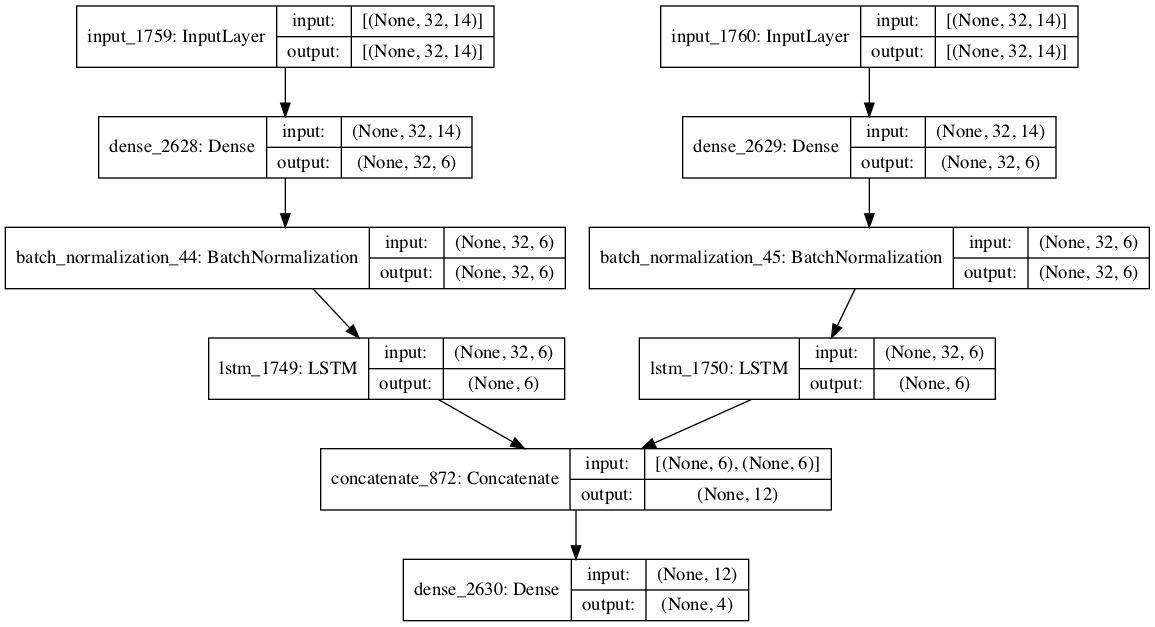

In [547]:
def create_Model(data_shape, num_reduced_channels, LSTM_cells):
    num_samples = data_shape[2]
    num_channels = data_shape[1]

    Input_K = tf.keras.Input(shape=(num_samples, num_channels))
    Input_A = tf.keras.Input(shape=(num_samples, num_channels))
    Input_K_f = tf.keras.layers.Dense(num_reduced_channels)(Input_K)
    Input_A_f = tf.keras.layers.Dense(num_reduced_channels)(Input_A)
    Input_K_f_norm = tf.keras.layers.BatchNormalization()(Input_K_f)
    Input_A_f_norm = tf.keras.layers.BatchNormalization()(Input_A_f)
    LSTM_K = tf.keras.layers.LSTM(LSTM_cells, dropout=0.6)(Input_K_f_norm)
    LSTM_A = tf.keras.layers.LSTM(LSTM_cells, dropout=0.6)(Input_A_f_norm)
    Merged_LSTM = tf.keras.layers.concatenate([LSTM_K, LSTM_A])
    Output = tf.keras.layers.Dense(4, activation='softmax')(Merged_LSTM)
    
    return tf.keras.Model(inputs=[Input_K, Input_A], outputs=Output)

model = create_Model(K_train.shape, 6, 6)
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# Training the architecture
----
We start by using the training data and shuffle it.

In [554]:
def train(K_train, A_train, epochs=1, LSTM_cells=5, lrate=3e-4, reduced_channel_dim=5):
    num_trials = K_train.shape[0]
    num_channels = K_train.shape[1]
    num_features = K_train.shape[2]
    
    model = create_Model(K_train.shape, reduced_channel_dim, LSTM_cells)
    optimizer = tf.keras.optimizers.Adam(lrate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    for epoch in range(epochs):
        for trial_idx in tqdm(range(num_trials), desc=f'Epoch {epoch}'):
            K_train_shuffled, A_train_shuffled, ONE_HOT_VEC_TRAIN_SHUFFLED = shuffle_sklearn(K_train, A_train, ONE_HOT_VEC_TRAIN)
            
            K_train_tf = tf.convert_to_tensor(K_train_shuffled)
            A_train_tf = tf.convert_to_tensor(A_train_shuffled)
            
            with tf.GradientTape() as tape:
                K_current = K_train_tf[trial_idx]
                A_current = A_train_tf[trial_idx]
                #K_train_shuffled, A_train_shuffled= shuffle_sklearn(K_train_tf[trial_idx], A_train_tf[trial_idx])
                tape.watch([K_current, A_current])
                k_t = tf.transpose(K_current)[None]
                a_t = tf.transpose(A_current)[None]
                output = model([k_t, a_t])
                c_loss = loss(ONE_HOT_VEC_TRAIN_SHUFFLED[trial_idx][None], output)

                gradients = tape.gradient(c_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
    return model
                
t_model = train(K_train, A_train, 5, 8, 0.005, 6)

Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████| 440/440 [00:38<00:00, 11.32it/s]


# Test
----
In this section we evaluate the performance of this architecture.

In [555]:
K_test_tf = tf.convert_to_tensor(K_test)
A_test_tf = tf.convert_to_tensor(A_test)

def accuracy(hits, N):
    acc = len(hits)/N*100
    print(f'Accuracy: {np.around(acc, 2)} %')
    return acc

def test(model, K_test_tf, A_test_tf, ONE_HOT_VEC_TEST):
    num_trials = tf.shape(K_test_tf)[0]
    num_channels = tf.shape(K_test_tf)[1]
    num_features = tf.shape(K_test_tf)[2]

    hits_test = []
    for trial_idx in range(num_trials):
        k_t = tf.transpose(K_test_tf[trial_idx])[None]
        a_t = tf.transpose(A_test_tf[trial_idx])[None]
        output = model([k_t, a_t])
        if ONE_HOT_VEC_TEST[trial_idx][np.argmax(output)] == 1:
            hits_test.append(1)
        else:
            pass

    return accuracy(hits_test, len(ONE_HOT_VEC_TEST))

res = test(t_model, K_test_tf, A_test_tf, ONE_HOT_VEC_TEST)

Accuracy: 31.0 %


# Grid search for Hyperparameter tuning
----
To optimize the results we run a grid search to finde the best hyperparameters.

In [474]:
LOGPATH = f'{os.getcwd()}/LOG/GridSearch_BCI'
os.makedirs(LOGPATH)

learning_rates = [1e-5, 5e-5, 1e-4, 3e-4, 5e-3, 1e-3, 1e-2]
c_hat = [3, 5, 7, 9]
lstm_cells = [1, 3, 5, 7, 9]
segment_length = [25, 50, 150, 250]

HP_LEARNING_RATE = hp.HParam('Learning Rate', hp.Discrete(learning_rates))
HP_FILTER_DIM = hp.HParam('Filter Dimension', hp.Discrete(c_hat))
HP_LSTM_CELLS = hp.HParam('LSTM Cells', hp.Discrete(lstm_cells))
HP_SEGMENT_LENGTH = hp.HParam('Segment length', hp.Discrete(segment_length))

METRIC_ACCURACY = 'accuracy'

def start_grid_search(hparams):
    segmented_data_train = segment_data(EEG_TRAIN, hparams[HP_SEGMENT_LENGTH])
    K_train, A_train = linear_regression(segmented_data_train)

    segmented_data_test = segment_data(EEG_TEST, hparams[HP_SEGMENT_LENGTH])
    K_test, A_test = linear_regression(segmented_data_test)
    
    trained_model = train(K_train_tf, A_train_tf,
                          epochs=2, 
                          LSTM_cells=hparams[HP_LSTM_CELLS], 
                          lrate=hparams[HP_LEARNING_RATE], 
                          reduced_channel_dim=hparams[HP_FILTER_DIM])
    accuracy = test(trained_model, K_test_tf, A_test_tf, ONE_HOT_VEC_TEST)
    
    return accuracy
    

def run(path, hparams, clist):
    with tf.summary.create_file_writer(path).as_default():
        hp.hparams(hparams)
        accuracy = start_grid_search(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

session_idx = 0
for lr_idx, lr in enumerate(HP_LEARNING_RATE.domain.values, 0):
    for fdim_idx, fdim in enumerate(HP_FILTER_DIM.domain.values, 0):
        for cells_idx, cells in enumerate(HP_LSTM_CELLS.domain.values, 0):
            for segment_idx, N in enumerate(HP_SEGMENT_LENGTH.domain.values, 0):
                
                hparams = {
                HP_LEARNING_RATE: lr,
                HP_FILTER_DIM: fdim,
                HP_LSTM_CELLS: cells,
                HP_SEGMENT_LENGTH: N
                }
                
                run(f'{LOGPATH}/{session_idx}', hparams, [])
                session_idx += 1


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [02:01<00:00, 41.03it/s]


Accuracy: 23.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.66it/s]


Accuracy: 32.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:42<00:00, 48.40it/s]


Accuracy: 21.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:42<00:00, 48.71it/s]


Accuracy: 19.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:43<00:00, 48.24it/s]


Accuracy: 25.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:42<00:00, 48.57it/s]


Accuracy: 30.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:42<00:00, 48.53it/s]


Accuracy: 22.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:42<00:00, 48.65it/s]


Accuracy: 22.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.56it/s]


Accuracy: 28.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.74it/s]


Accuracy: 21.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.75it/s]


Accuracy: 27.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.80it/s]


Accuracy: 21.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.12it/s]


Accuracy: 32.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.08it/s]


Accuracy: 26.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.11it/s]


Accuracy: 27.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.30it/s]


Accuracy: 26.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.37it/s]


Accuracy: 27.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.24it/s]


Accuracy: 28.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.22it/s]


Accuracy: 30.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.07it/s]


Accuracy: 29.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:43<00:00, 47.95it/s]


Accuracy: 22.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:43<00:00, 48.24it/s]


Accuracy: 24.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:46<00:00, 46.93it/s]


Accuracy: 24.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.07it/s]


Accuracy: 21.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.34it/s]


Accuracy: 33.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.47it/s]


Accuracy: 13.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.55it/s]


Accuracy: 25.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.87it/s]


Accuracy: 20.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.28it/s]


Accuracy: 28.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.52it/s]


Accuracy: 24.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.55it/s]


Accuracy: 29.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:46<00:00, 46.61it/s]


Accuracy: 25.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.29it/s]


Accuracy: 26.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.36it/s]


Accuracy: 31.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.50it/s]


Accuracy: 24.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.46it/s]


Accuracy: 21.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.45it/s]


Accuracy: 28.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.58it/s]


Accuracy: 24.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.57it/s]


Accuracy: 29.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:46<00:00, 46.61it/s]


Accuracy: 27.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:44<00:00, 47.88it/s]


Accuracy: 32.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:43<00:00, 47.94it/s]


Accuracy: 26.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:43<00:00, 47.95it/s]


Accuracy: 21.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:43<00:00, 47.99it/s]


Accuracy: 30.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:45<00:00, 47.38it/s]


Accuracy: 30.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.32it/s]


Accuracy: 20.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.33it/s]


Accuracy: 19.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.49it/s]


Accuracy: 27.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:48<00:00, 46.10it/s]


Accuracy: 25.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.31it/s]


Accuracy: 28.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.19it/s]


Accuracy: 25.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:48<00:00, 46.14it/s]


Accuracy: 26.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.24it/s]


Accuracy: 30.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.17it/s]


Accuracy: 24.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:48<00:00, 46.09it/s]


Accuracy: 24.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:47<00:00, 46.29it/s]


Accuracy: 25.5 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [01:48<00:00, 46.00it/s]


Accuracy: 26.0 %


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 4984/4984 [02:01<00:00, 41.15it/s]


Accuracy: 17.5 %


Epoch 1:  25%|█████████████████▊                                                      | 1237/4984 [00:35<01:46, 35.16it/s]


KeyboardInterrupt: 

In [ ]:
def sliding_window(data, win_overlap, win_length):
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    num_samples = data.shape[2]

    assert num_samples % win_length == 0
    assert (num_samples * win_overlap) % 1 == 0
    
    offset = (1-win_overlap) * win_length
    num_windows = int((num_samples - win_length)//offset + 1)

    sliced_eeg_data = np.zeros(shape=(num_trials, num_windows, num_channels,  win_length))
    for trial_idx in range(num_trials):
        for window_idx in range(num_windows):
            for channel_idx in range(num_channels):
                upper_border = int(window_idx*offset)
                lower_border = int(window_idx*offset+win_length)
                sliced_eeg_data[trial_idx][window_idx][channel_idx] = data[trial_idx][channel_idx][upper_border:lower_border]
    
    return sliced_eeg_data

def statistical_features(data):
    # [Mean, Energy, Standard Deviation, Max]
    stat_features = np.zeros(shape=(len(data)*num_features))
    for idx, sample in enumerate(data, 0):
        mean = np.mean(sample)
        energy = np.sum(np.array([x**2 for x in sample]))
        std_dev = np.std(sample)
        max_val = np.amax(sample)
        min_val = np.amin(sample)
        stat_features[idx*num_features:(idx+1)*num_features] = np.array([mean, energy, std_dev, max_val, min_val])
    
    return stat_features

def discrete_wavelet_transform(raw_data, dwt_level):
    num_labels = raw_data.shape[0]
    num_windows = raw_data.shape[1]
    num_channels = raw_data.shape[2]
    observations = raw_data.shape[3]
    
    num_features = 4
    dwt_features = np.zeros(shape=(num_labels, num_windows, num_channels, num_features*dwt_level))
    
    for label_idx in range(num_labels):
        tmp = np.zeros(shape=(num_channels, num_features*dwt_level))
        for window_idx in range(num_windows):
            for channel_idx in range(num_channels):
                # Shape: [cA_n, cD_n, cD_n-1, …, cD2, cD1] 
                dwt_coefficients = pywt.wavedec(raw_data[label_idx, channel_idx], 'db4', level=dwt_level)[1:]
                stat_features = statistical_features(dwt_coefficients, 4)
                tmp[channel_idx] = stat_features
            dwt_features[label_idx] = tmp
    
    return dwt_features

def prinicipal_component_analysis(eeg_data, principle_components):
    num_labels = eeg_data.shape[0]
    num_windows = eeg_data.shape[1]
    num_channels = eeg_data.shape[2]
    observations = eeg_data.shape[3]
    
    features = np.zeros(shape=(num_labels, num_windows, principle_components, observations))
    
    for label_idx in range(num_labels):
        for window_idx in range(num_windows):
            segment = eeg_data[label_idx][window_idx]
            segment_mean = np.mean(segment, axis=1)[None].T
            centred_segment = segment - np.tile(segment_mean, (1, observations))
            segment_cov = np.matmul(centred_segment, centred_segment.T)/observations
            
            eig_values, eig_vector = np.linalg.eig(segment_cov)
            pca_result = np.matmul(eig_vector[:,0:principle_components].T, segment)
            features[label_idx][window_idx] = pca_result
    
    return features

def bandpass_filtering(frequency_bands, raw_data):
    num_labels = raw_data.shape[0]
    num_channels = raw_data.shape[1]
    observations = raw_data.shape[2]
    num_bands = len(frequency_bands)
    
    band_filtered_data = np.zeros(shape=(num_labels, num_channels, num_bands, observations))
    for label_idx in range(num_labels):
        for channel_idx in range(num_channels):
            for band_idx, freq_band in enumerate(frequency_bands, 0):
                sos = butter(N=10, Wn=freq_band, btype='bandpass', output='sos')
                filtered_signal = sosfiltfilt(sos, raw_data[label_idx, channel_idx])
                band_filtered_data[label_idx, channel_idx, band_idx] = np.copy(filtered_signal)
    
    return band_filtered_data

#frequency_bands = np.array([[4, 8], [8, 16], [16, 32], [32, 63]])/64
#result = bandpass_filtering(frequency_bands, data)

def hilbert_transform(dwt_data):
    hilbert_env_data = np.abs(hilbert(dwt_data))
    